In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

In [13]:
df_x86 = pd.read_csv("data/sort_x86_64.csv")
df_riscv = pd.read_csv("data/sort_riscv64.csv")

In [14]:
df_list = [df_x86, df_riscv]

In [15]:
df_x86.head()

,array_length,block_size,architecture,I1_misses,D1mr,D1mw,walltime
0,32,32,x86_64,2405,1619,698,0.045095
1,64,32,x86_64,2402,1619,702,0.049084
2,128,32,x86_64,2411,1619,710,0.056757
3,64,64,x86_64,1431,1061,370,0.038379
4,128,64,x86_64,1434,1061,374,0.044810


## Walltime

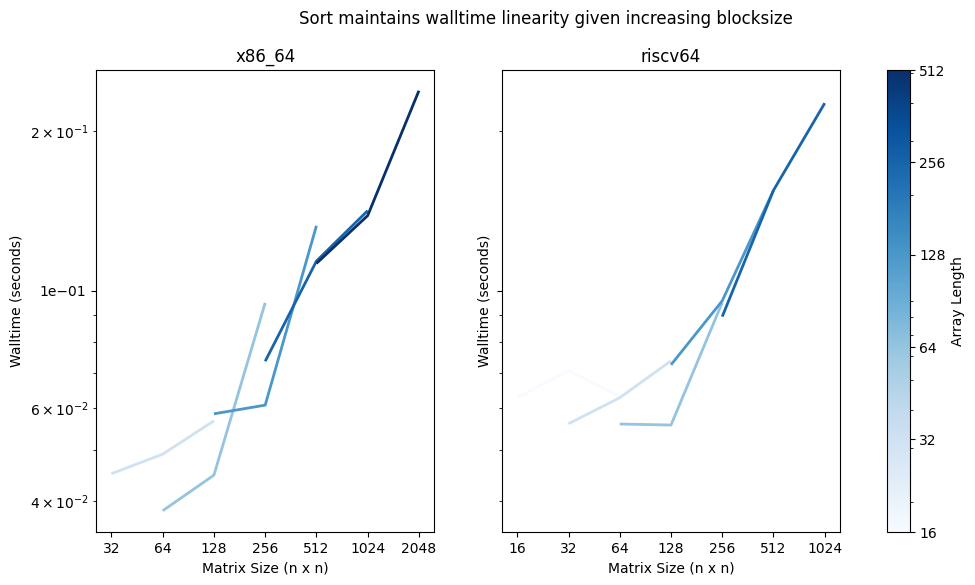

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.suptitle("Sort maintains walltime linearity given increasing blocksize")

# Prepare for shared colorbar
all_block_sizes = []

# Preprocess to gather all block sizes across all dataframes
for df in df_list:
    for bs in df["block_size"].unique():
        all_block_sizes.append(bs)
all_block_sizes = np.array(sorted(set(all_block_sizes)), dtype=int)
norm = LogNorm(vmin=all_block_sizes.min(), vmax=all_block_sizes.max())
cmap = plt.cm.Blues
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for colorbar

# Plot each DataFrame in its subplot
for loc, df in enumerate(df_list):
    segments = []
    block_sizes = []

    for bs, group in df.groupby("block_size"):
        x = group["array_length"].values
        y = group["walltime"].values
        points = np.column_stack([x, y])
        segments.append(points)
        block_sizes.append(bs)

    block_sizes = np.array(block_sizes, dtype=int)
    sorted_idx = np.argsort(block_sizes)
    segments = [segments[i] for i in sorted_idx]
    block_sizes = block_sizes[sorted_idx]

    colors = cmap(norm(block_sizes))
    lc = LineCollection(segments, colors=colors, linewidths=2)
    ax[loc].add_collection(lc)

    ax[loc].autoscale()
    ax[loc].set_xscale("log", base=2)
    ax[loc].set_yscale("log", base=10)

    ax[loc].xaxis.set_major_locator(LogLocator(base=2))
    ax[loc].xaxis.set_major_formatter(LogFormatter(base=2))

    ax[loc].yaxis.set_major_locator(LogLocator(base=10))
    ax[loc].yaxis.set_major_formatter(LogFormatter(base=10))
    
    ax[loc].set_xlabel("Matrix Size (n x n)")
    ax[loc].set_ylabel("Walltime (seconds)")
    ax[loc].set_title(f"{df['architecture'].unique()[0]}")

# Add one shared colorbar
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), label="Array Length")
cbar.set_ticks(all_block_sizes)
cbar.set_ticklabels([str(bs) for bs in all_block_sizes])

plt.show()

## L1 Cache Misses

### Instruction cache misses

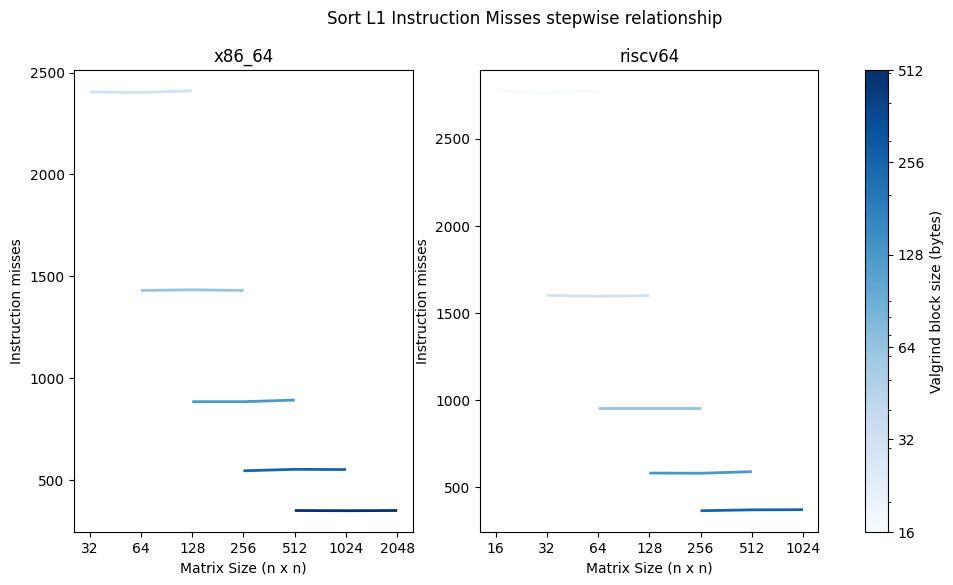

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
fig.suptitle("Sort L1 Instruction Misses stepwise relationship")

# Prepare for shared colorbar
all_block_sizes = []

# Preprocess to gather all block sizes across all dataframes
for df in df_list:
    for bs in df["block_size"].unique():
        all_block_sizes.append(bs)
all_block_sizes = np.array(sorted(set(all_block_sizes)), dtype=int)
norm = LogNorm(vmin=all_block_sizes.min(), vmax=all_block_sizes.max())
cmap = plt.cm.Blues
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for colorbar

# Plot each DataFrame in its subplot
for loc, df in enumerate(df_list):
    segments = []
    block_sizes = []

    for bs, group in df.groupby("block_size"):
        x = group["array_length"].values
        y = group["I1_misses"].values
        points = np.column_stack([x, y])
        segments.append(points)
        block_sizes.append(bs)

    block_sizes = np.array(block_sizes, dtype=int)
    sorted_idx = np.argsort(block_sizes)
    segments = [segments[i] for i in sorted_idx]
    block_sizes = block_sizes[sorted_idx]

    colors = cmap(norm(block_sizes))
    lc = LineCollection(segments, colors=colors, linewidths=2)
    ax[loc].add_collection(lc)

    ax[loc].autoscale()
    ax[loc].set_xscale("log", base=2)
    # ax[loc].set_yscale("log", base=10)

    ax[loc].xaxis.set_major_locator(LogLocator(base=2))
    ax[loc].xaxis.set_major_formatter(LogFormatter(base=2))
    
    ax[loc].set_xlabel("Matrix Size (n x n)")
    ax[loc].set_ylabel("Instruction misses")
    ax[loc].set_title(f"{df['architecture'].unique()[0]}")

# Add one shared colorbar
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), label="Valgrind block size (bytes)")
cbar.set_ticks(all_block_sizes)
cbar.set_ticklabels([str(bs) for bs in all_block_sizes])

plt.show()

### Data Cache Misses

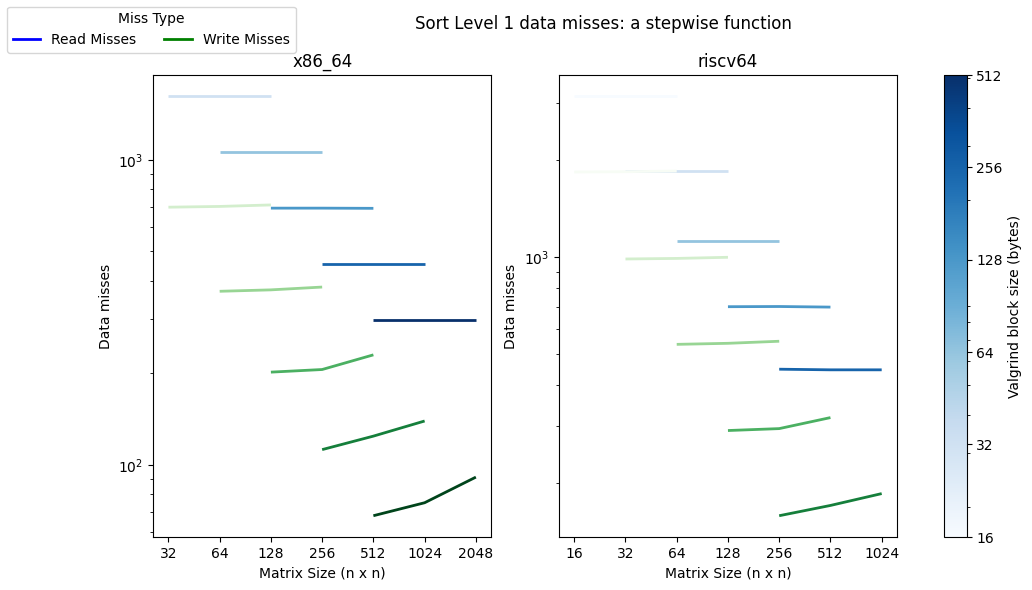

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
fig.suptitle("Sort Level 1 data misses: a stepwise function")

# Prepare for shared colorbar
all_block_sizes = []

# Preprocess to gather all block sizes across all dataframes
for df in df_list:
    for bs in df["block_size"].unique():
        all_block_sizes.append(bs)
all_block_sizes = np.array(sorted(set(all_block_sizes)), dtype=int)
norm = LogNorm(vmin=all_block_sizes.min(), vmax=all_block_sizes.max())
cmap_r = plt.cm.Blues
cmap_w = plt.cm.Greens
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Needed for colorbar

# Plot each DataFrame in its subplot
for loc, df in enumerate(df_list):
    read_segments, write_segments = [], []
    block_sizes = []

    for bs, group in df.groupby("block_size"):
        x = group["array_length"].values
        y_read = group["D1mr"].values # level 1 data read misses
        y_write = group["D1mw"].values # level 1 data write misses
        read_segments.append(np.column_stack([x, y_read]))
        write_segments.append(np.column_stack([x, y_write]))
        block_sizes.append(bs)

    block_sizes = np.array(block_sizes, dtype=int)
    sorted_idx = np.argsort(block_sizes)
    read_segments = [read_segments[i] for i in sorted_idx]
    write_segments = [write_segments[i] for i in sorted_idx]
    block_sizes = block_sizes[sorted_idx]

    read_colors = cmap_r(norm(block_sizes))
    write_colors = cmap_w(norm(block_sizes))

    colors = cmap(norm(block_sizes))
    lc_read = LineCollection(read_segments, colors=read_colors, linewidths=2, label="Read Misses")
    lc_write = LineCollection(write_segments, colors=write_colors, linewidths=2, label="Write Misses")

    ax[loc].add_collection(lc_read)
    ax[loc].add_collection(lc_write)

    ax[loc].autoscale()
    ax[loc].set_xscale("log", base=2)
    ax[loc].set_yscale("log", base=10)

    ax[loc].xaxis.set_major_locator(LogLocator(base=2))
    ax[loc].xaxis.set_major_formatter(LogFormatter(base=2))
    
    ax[loc].set_xlabel("Matrix Size (n x n)")
    ax[loc].set_ylabel("Data misses")
    ax[loc].set_title(f"{df['architecture'].unique()[0]}")

# Add one shared colorbar
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), label="Valgrind block size (bytes)")
cbar.set_ticks(all_block_sizes)
cbar.set_ticklabels([str(bs) for bs in all_block_sizes])

custom_legend = [
    Line2D([0], [0], color='blue', lw=2, label='Read Misses'),
    Line2D([0], [0], color='green', lw=2, label='Write Misses')
]

fig.legend(handles=custom_legend, loc='upper left', ncol=2, title="Miss Type")
plt.show()